# t-tests in R


In this lesson, we will perform t-tests for individual regression parameters in R. To do this, we'll use a [dataset](https://dasl.datadescription.com/datafile/amazon-books/?_sfm_methods=Multiple+Regression&_sfm_cases=4+59943) about book prices from Amazon. The data consists of data on $n = 325$ books and includes measurements of:

- `aprice`: The price listed on Amazon (dollars)


- `lprice`: The book's list price (dollars)


- `weight`: The book's weight (ounces)


- `pages`: The number of pages in the book


- `height`: The book's height (inches)


- `width`: The book's width (inches)


- `thick`: The thickness of the book (inches)


- `cover`: Whether the book is a hard cover of paperback.


- And other variables...

We'll explore a model that will use `lprice`, `pages`, and `width` to predict `aprice`. But first, we'll do some work cleaning and wrangling the data.

## Data cleaning and wrangling

Let's read in the data and see if there are any missing values.

In [18]:
library(RCurl) #a package that includes the function getURL(), which allows for reading data from github.
library(ggplot2)
url = getURL(paste0("https://raw.githubusercontent.com/bzaharatos/",
                    "-Statistical-Modeling-for-Data-Science-Applications/",
                    "master/Modern%20Regression%20Analysis%20/Datasets/amazon.txt"))
amazon = read.csv(text = url, sep = "\t")
names(amazon)
df = data.frame(aprice = amazon$Amazon.Price, lprice = as.numeric(amazon$List.Price),  
                pages = amazon$NumPages, width = amazon$Width, weight = amazon$Weight..oz,  
                height = amazon$Height, thick = amazon$Thick, cover = amazon$Hard..Paper)

summary(df)
which(is.na(df$lprice))

[1] "Title"        "Author"       "List.Price"   "Amazon.Price" "Hard..Paper" 
 [6] "NumPages"     "Publisher"    "Pub.year"     "ISBN.10"      "Height"      
[11] "Width"        "Thick"        "Weight..oz."

     aprice           lprice           pages           width      
 Min.   :  0.77   Min.   :  1.50   Min.   : 24.0   Min.   :4.100  
 1st Qu.:  8.60   1st Qu.: 13.95   1st Qu.:208.0   1st Qu.:5.200  
 Median : 10.20   Median : 15.00   Median :320.0   Median :5.400  
 Mean   : 13.33   Mean   : 18.58   Mean   :335.9   Mean   :5.585  
 3rd Qu.: 13.13   3rd Qu.: 19.95   3rd Qu.:416.0   3rd Qu.:5.900  
 Max.   :139.95   Max.   :139.95   Max.   :896.0   Max.   :9.500  
                  NA's   :1        NA's   :2       NA's   :5      
     weight          height           thick        cover  
 Min.   : 1.20   Min.   : 5.100   Min.   :0.1000   H: 89  
 1st Qu.: 7.80   1st Qu.: 7.900   1st Qu.:0.6000   P:236  
 Median :11.20   Median : 8.100   Median :0.9000          
 Mean   :12.49   Mean   : 8.163   Mean   :0.9077          
 3rd Qu.:16.00   3rd Qu.: 8.500   3rd Qu.:1.1000          
 Max.   :35.20   Max.   :12.100   Max.   :2.1000          
 NA's   :9       NA's   :4        NA's   :1        

[1] 205

From the summary, we can see that there are missing values in the dataset, coded as `NA`. There are many ways to deal with missing data. Suppose that sample unit $i$ has a missing measurement for variable $z_j$. We could:

1. Delete sample unit $i$ from the dataset, i.e., delete the entire row. That might be reasonable if there are very view missing values and if we think the values are missing at random.

2. Delete the variable $z_j$ from the dataset, i.e., delete the entire column. This might be reasonable if there are many many other missing values for $z_j$ and if we think $z_j$ might not be neccesary for our overall prediction/explanation goals.

3.  Impute missing values by substituting each missing value with an estimate.

For more information on missing values, see this [resource](https://www.bu.edu/sph/files/2014/05/Marina-tech-report.pdf).

Since most of our columns/variables are not missing values, and since these variables will be useful to us in our analysis, option 2 seems unreasonable. Let's first try option 3: impute the missing values of `lprice`, `pages`, `width`, `weight`, `height`, and `thick` with the mean of each.

In [4]:
df$lprice[which(is.na(df$lprice))] = mean(df$lprice, na.rm = TRUE)
df$weight[which(is.na(df$weight))] = mean(df$weight, na.rm = TRUE)
df$pages[which(is.na(df$pages))] = mean(df$pages, na.rm = TRUE)
df$height[which(is.na(df$height))] = mean(df$height, na.rm = TRUE)
df$width[which(is.na(df$width))] = mean(df$width, na.rm = TRUE)
df$thick[which(is.na(df$thick))] = mean(df$thick, na.rm = TRUE)
summary(df)

     aprice           lprice           pages           width      
 Min.   :  0.77   Min.   :  1.50   Min.   : 24.0   Min.   :4.100  
 1st Qu.:  8.60   1st Qu.: 13.95   1st Qu.:208.0   1st Qu.:5.200  
 Median : 10.20   Median : 15.00   Median :320.0   Median :5.400  
 Mean   : 13.33   Mean   : 18.58   Mean   :335.9   Mean   :5.585  
 3rd Qu.: 13.13   3rd Qu.: 19.95   3rd Qu.:416.0   3rd Qu.:5.900  
 Max.   :139.95   Max.   :139.95   Max.   :896.0   Max.   :9.500  
     weight          height           thick        cover  
 Min.   : 1.20   Min.   : 5.100   Min.   :0.1000   H: 89  
 1st Qu.: 7.80   1st Qu.: 7.900   1st Qu.:0.6000   P:236  
 Median :11.20   Median : 8.100   Median :0.9000          
 Mean   :12.49   Mean   : 8.163   Mean   :0.9077          
 3rd Qu.:16.00   3rd Qu.: 8.500   3rd Qu.:1.1000          
 Max.   :35.20   Max.   :12.100   Max.   :2.1000          

This removed the `NA` values, and substituted them with the mean of all the other values in the corresponding column. This isn't always a good idea, however. Let's take a look at a scatter plot of the Amazon price as a function of the list price (with points colored according to whether they are hardcover of paperback).

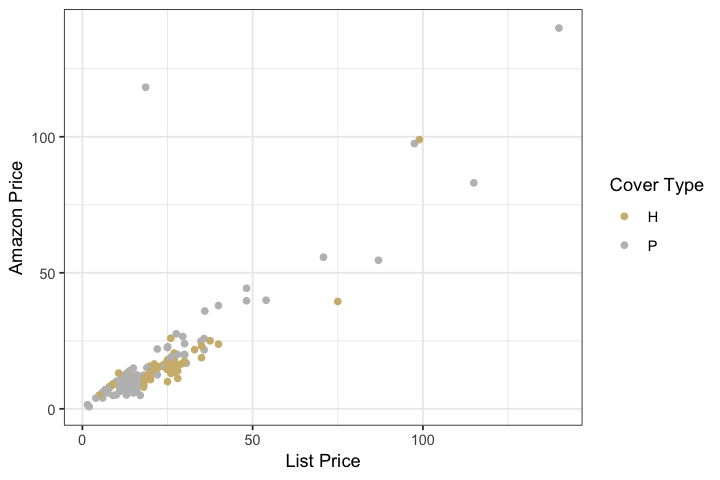

In [5]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(df) + 
    geom_point(aes(x = lprice, y = aprice, colour = cover)) +
    scale_colour_manual(name = 'Cover Type', values = setNames(c('#CFB87C','grey'),c("H", "P"))) +
    theme_bw() +
    xlab('List Price') + ylab('Amazon Price')

Arguably, there are many outliers here, but some of them won't really make a difference with respect to the fit of a linear model. However, one clearly will, namely the grey point that has a very high Amazon price and a relatively low list price. We might call this point an *influential point*, since it would influence the fit of the regression model. Let's see if this is the value that we imputed:

In [6]:
which(df$aprice >100 & df$lprice < 50)
amazon[205,]

[1] 205

,Title,Author,List.Price,Amazon.Price,Hard..Paper,NumPages,Publisher,Pub.year,ISBN.10,Height,Width,Thick,Weight..oz.
205,The 80 10 10 Diet,Graham,NA,118.21,P,340,foodnsport Press,2006,1893831248,8.9,6,0.8,16


It is! This suggests that the imputation method probably did more harm than good, since it created a list price value that does not follow the trend in the data. Of course it's *possible* that this is the true list price for this book, but given that Amazon rarely has this much of a gap between its prices and list prices is a red flag! So instead, we'll remove the unit. Note though, that in a real data analysis, we should investigate the cause of the missing values, and perhaps try a more sophisticated imputation method if we think the values are not missing at random. Also, we should do similar explorations to see whether the other imputations that we performed cause similar problems. For now, we'll leave the other variables as is.

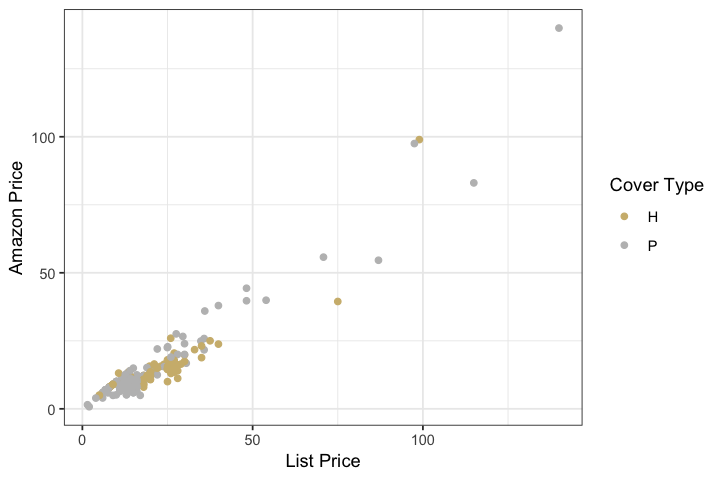

In [7]:
df = df[-205,]
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(df) + 
    geom_point(aes(x = lprice, y = aprice, colour = cover)) +
    scale_colour_manual(name = 'Cover Type', values = setNames(c('#CFB87C','grey'),c("H", "P"))) +
    theme_bw() +
    xlab('List Price') + ylab('Amazon Price')

There's clearly a strong linear relationship between the two prices. Let's look at relationships between other variables.

corrplot 0.84 loaded


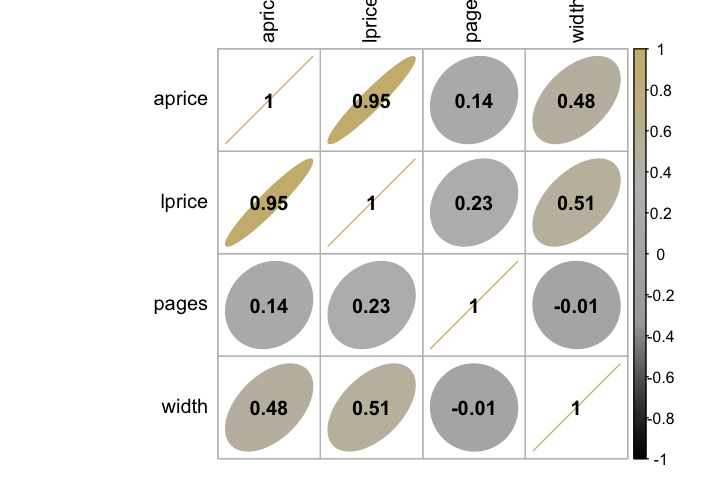

In [8]:
library(corrplot)
col4 = colorRampPalette(c("black", "darkgrey", "grey","#CFB87C"))
corrplot(cor(df[,1:4]), method = "ellipse", col = col4(100),  addCoef.col = "black", tl.col = "black")

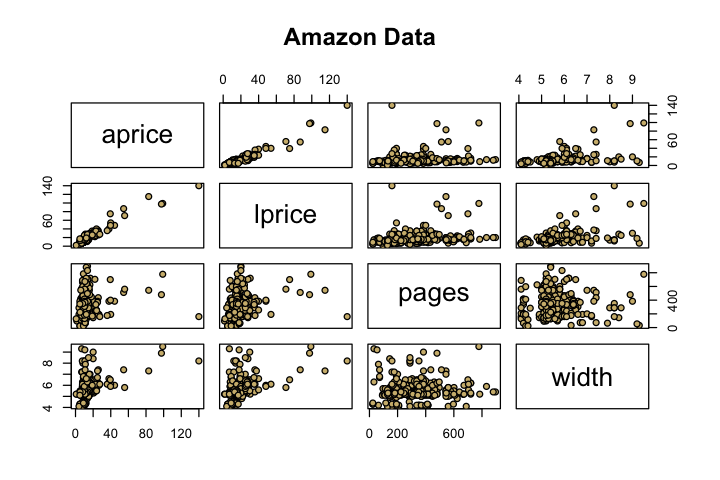

In [9]:
pairs(df[,1:4], main = "Amazon Data", pch = 21, 
      bg = c("#CFB87C"))

Some appear linear, but outliers exist. In a full analysis, we would work on identifying those outliers and decide why they were so different than other measurements. For the purposes of learning something about statistical inference in regression, we'll continue with the data as is; but note that outliers can impact statistical significance.

## Linear modeling

Let's model the Amazon price as a function of the list price, the number of pages, and the width of the book. When conducting hypothesis tests, let's set $\alpha = 0.05$. 

In [10]:
lm_amazon = lm(aprice ~ lprice + pages + width, data = df)
summary(lm_amazon)


Call:
lm(formula = aprice ~ lprice + pages + width, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.3092  -1.7824  -0.0695   1.3374  22.9248 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.862994   1.573723   0.548    0.584    
lprice       0.854834   0.017848  47.895  < 2e-16 ***
pages       -0.006044   0.001348  -4.482 1.03e-05 ***
width       -0.305456   0.285426  -1.070    0.285    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.774 on 320 degrees of freedom
Multiple R-squared:  0.9089,	Adjusted R-squared:  0.908 
F-statistic:  1064 on 3 and 320 DF,  p-value: < 2.2e-16


Let $\beta_{width}$ be the parameter associated with the `width` predictor. Consider the hypothesis test:

$$H_0: \beta_{width} = 0 \,\,\, vs \,\,\, H_1: \beta_{width} \ne 0.$$

Notice that the p-value for this test is $0.285$, which is not less than $\alpha$. Thus, the parameter associated with `width` is not statistically significant at the $\alpha = 0.05$ level. As such, we do not have evidence that that parameter is different from zero, and, equivalently, we don't have statistical evidence to suggest that `width` should stay in the model.

Interestingly, the number of pages *is* statistically significant, but the *magnitude*, i.e., size of the association, of the parameter estimate is much lower than the estimate for the width:

$$\big| \, \widehat\beta_{pages}\, \big| = 0.006 < \big| \,  \widehat\beta_{width}\, \big|  = 0.305. $$

So, it may be that `pages` is statistically significant, but practically insignificant. To explore this, let's interpret the `pages` estimate: (assuming the model is roughly correct), adjusting for the list price and width, for every additional page added to a book, we can expect the amazon price to decrease by $\$0.006$, less than a penny. That is, an increase of 100 pages - a relatively large difference - is associated with a $\$0.60$ increase. Is this worth keeping in the model, even though it's *statistically* significant? It depends! Some important questions are:

1. Are researchers counting book pages themselves, and thus spending time and money on it, or is this page data easily available? 


2. How precise do our predictions need to be?

If researchers counting book pages themselves, and if predictions don't need to be all that precise, using `pages` as a predictor might be more trouble than it's worth! However, often, page information is available from publishers, and competing with Amazon prices might require a highly precise model. So, researchers might opt to keep `pages` in the model. In short, answering this question requires knowledge of the domain area and data collection process!